In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '05'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [3]:
idx_explain = 0

In [4]:
feature1 = []
feature2 = []
for x in X:
    feature1.append(x[0])
    feature2.append(x[1])

feature1 = np.asarray(feature1)
feature2 = np.asarray(feature2)

y = y.astype(str)

d = {'y': y, 'feature_1': feature1, 'feature_2': feature2}

df = pd.DataFrame(d)

dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [5]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [6]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([1497,  639]))


Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


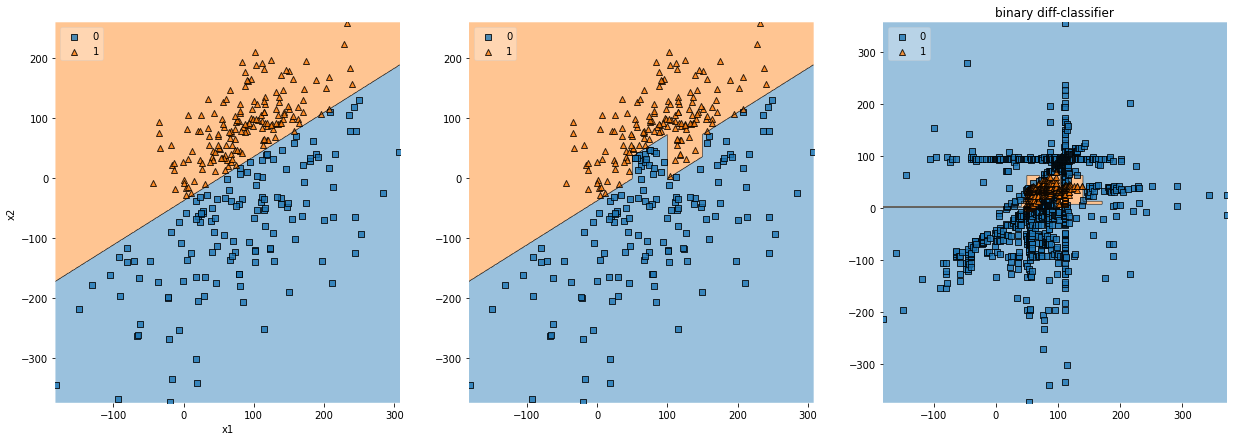

In [7]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.integer), clf=dc_full, ax=ax[2], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('binary diff-classifier')

plt.show()

[Text(550.1116071428571, 871.1538461538462, 'x2 <= 62.0\ngini = 0.419\nsamples = 2136\nvalue = [1497, 639]\nclass = no_diff'),
 Text(352.9017857142857, 801.4615384615385, 'x2 <= 13.5\ngini = 0.498\nsamples = 1369\nvalue = [731, 638]\nclass = no_diff'),
 Text(124.55357142857143, 731.7692307692307, 'x2 <= 2.5\ngini = 0.216\nsamples = 705\nvalue = [618, 87]\nclass = no_diff'),
 Text(33.214285714285715, 662.0769230769231, 'x2 <= 0.5\ngini = 0.02\nsamples = 487\nvalue = [482, 5]\nclass = no_diff'),
 Text(16.607142857142858, 592.3846153846154, 'gini = 0.0\nsamples = 460\nvalue = [460, 0]\nclass = no_diff'),
 Text(49.82142857142857, 592.3846153846154, 'x1 <= 54.5\ngini = 0.302\nsamples = 27\nvalue = [22, 5]\nclass = no_diff'),
 Text(33.214285714285715, 522.6923076923076, 'x1 <= 53.5\ngini = 0.278\nsamples = 6\nvalue = [1, 5]\nclass = diff'),
 Text(16.607142857142858, 453.0, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = diff'),
 Text(49.82142857142857, 453.0, 'x2 <= 1.5\ngini = 0.444\nsamp

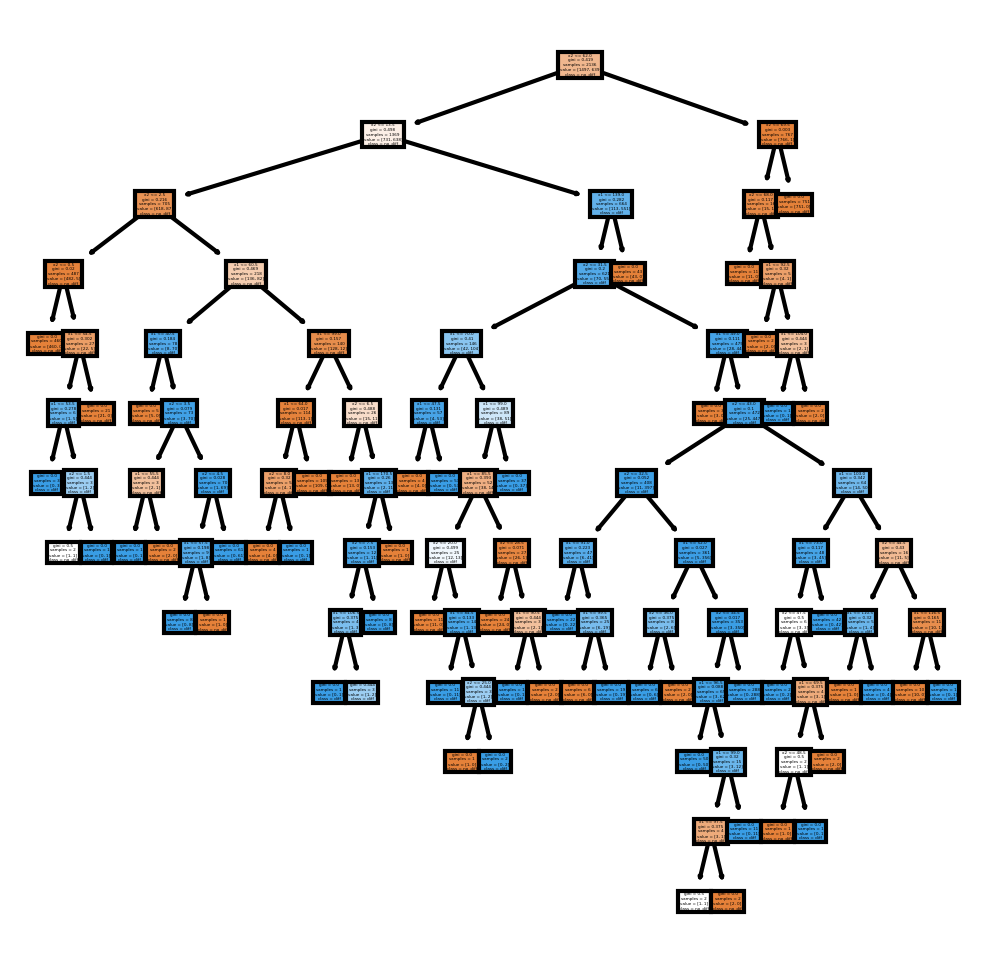

In [8]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [9]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{feature_2 <= 62.0, feature_2 <= 13.5, feature_2 <= 2.5, feature_2 > 0.5, feature_1 <= 54.5, feature_1 <= 53.5}'}
{'diff': '{feature_2 <= 62.0, feature_2 <= 13.5, feature_2 <= 2.5, feature_2 > 0.5, feature_1 <= 54.5, feature_1 > 53.5, feature_2 > 1.5}'}
{'diff': '{feature_2 <= 62.0, feature_2 <= 13.5, feature_2 > 2.5, feature_1 <= 60.5, feature_1 > 40.5, feature_2 <= 3.5, feature_1 <= 55.5}'}
{'diff': '{feature_2 <= 62.0, feature_2 <= 13.5, feature_2 > 2.5, feature_1 <= 60.5, feature_1 > 40.5, feature_2 > 3.5, feature_2 <= 4.5, feature_1 <= 57.5}'}
{'diff': '{feature_2 <= 62.0, feature_2 <= 13.5, feature_2 > 2.5, feature_1 <= 60.5, feature_1 > 40.5, feature_2 > 3.5, feature_2 > 4.5}'}
{'diff': '{feature_2 <= 62.0, feature_2 <= 13.5, feature_2 > 2.5, feature_1 > 60.5, feature_1 <= 99.0, feature_1 <= 64.0, feature_2 > 8.0}'}
{'diff': '{feature_2 <= 62.0, feature_2 <= 13.5, feature_2 > 2.5, feature_1 > 60.5, feature_1 > 99.0, feature_2 > 6.5, feature_1 <= 170.5, feature_2 <= 7.5

## Multiclass difference explanations

In [10]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [11]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [12]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 3, 4]), array([1192,  810,  110,  153]))


You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


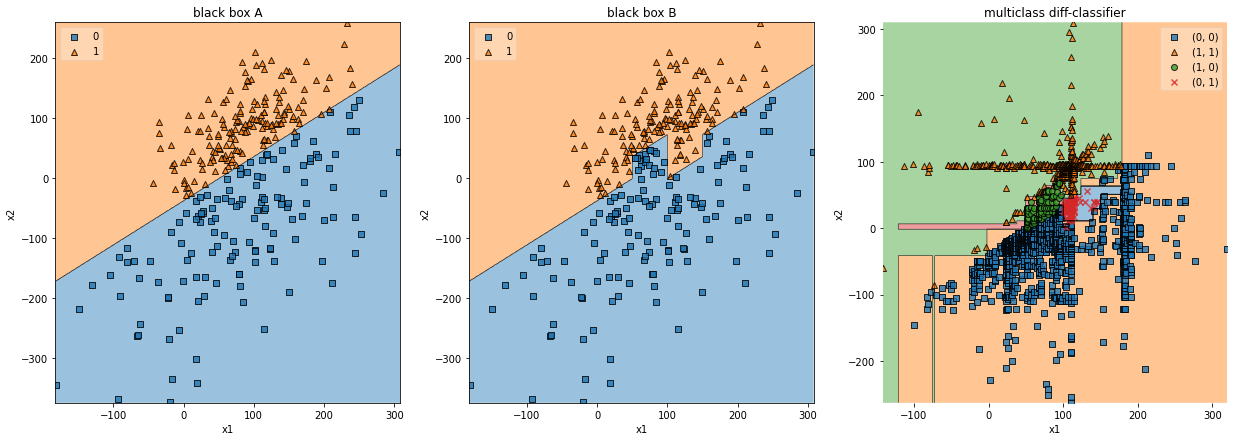

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, hide_spines=False)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, hide_spines=False)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.int64), clf=dc_full, ax=ax[2], legend=2)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[1])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(592.875, 868.25, 'x2 <= 50.5\ngini = 0.588\nsamples = 2265\nvalue = [1192, 810, 110, 153]\nclass = (0, 0)'),
 Text(339.45000000000005, 792.75, 'x2 <= 10.5\ngini = 0.329\nsamples = 1410\nvalue = [1141, 19, 98, 152]\nclass = (0, 0)'),
 Text(190.65, 717.25, 'x2 <= 5.0\ngini = 0.039\nsamples = 1006\nvalue = [986, 7, 12, 1]\nclass = (0, 0)'),
 Text(120.9, 641.75, 'x1 <= -120.5\ngini = 0.019\nsamples = 960\nvalue = [951, 5, 3, 1]\nclass = (0, 0)'),
 Text(102.30000000000001, 566.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0]\nclass = (1, 1)'),
 Text(139.5, 566.25, 'x2 <= -0.5\ngini = 0.017\nsamples = 959\nvalue = [951, 4, 3, 1]\nclass = (0, 0)'),
 Text(93.0, 490.75, 'x1 <= -2.0\ngini = 0.009\nsamples = 908\nvalue = [904, 4, 0, 0]\nclass = (0, 0)'),
 Text(74.4, 415.25, 'x2 <= -41.0\ngini = 0.116\nsamples = 65\nvalue = [61, 4, 0, 0]\nclass = (0, 0)'),
 Text(55.800000000000004, 339.75, 'x1 <= -71.5\ngini = 0.032\nsamples = 62\nvalue = [61, 1, 0, 0]\nclass = (0, 0)'),
 Text(37.2, 264.25

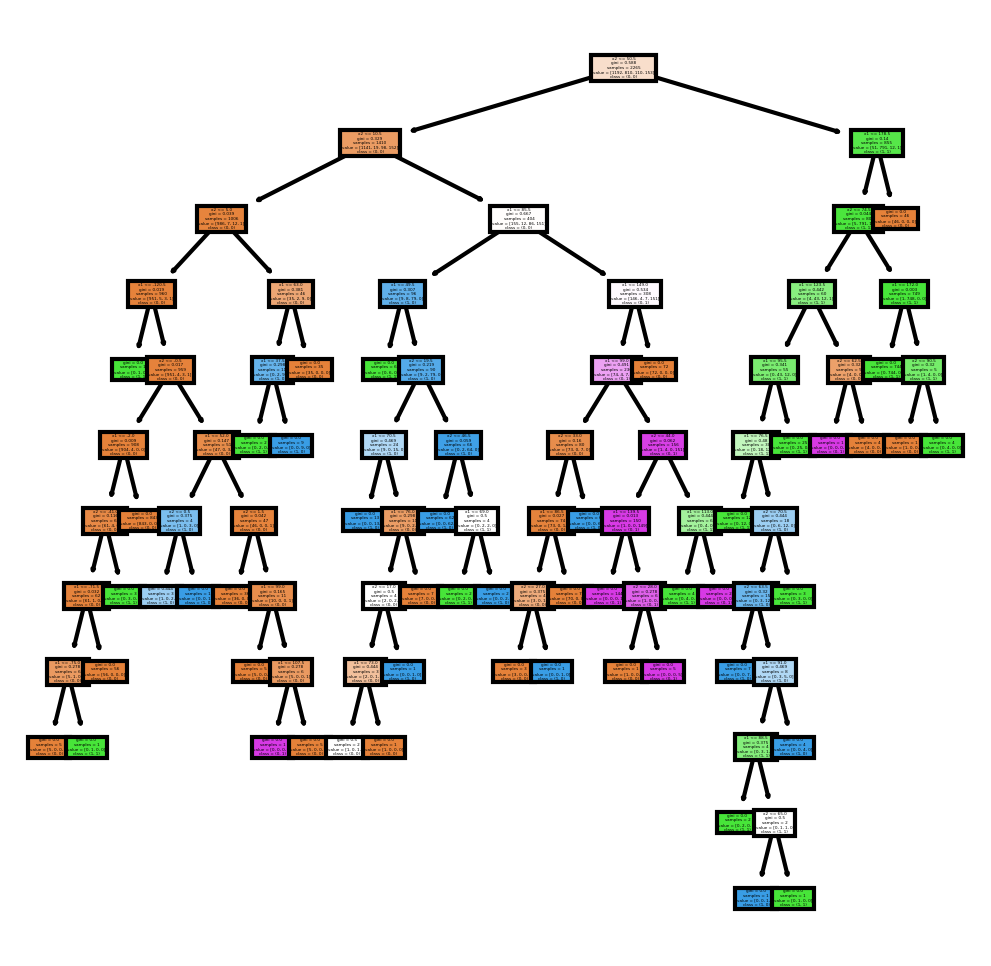

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)